In [2]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math
from scipy.optimize import curve_fit


top_level=f'{os.getcwd()}/../../../'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import epix_hr_single_10k
import ePixViewer.Cameras as cameras

%run ../../ASIC_V4/supportFunctions.ipynb

In [3]:
# Create and start the root class
root = epix_hr_single_10k.RootLCLSIITiming(
    top_level   = top_level,
    sim         = False,
    dev         = '/dev/datadev_0',
    asicVersion = 4
)
root.start()

Simulation mode : False
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)


In [4]:
# Create useful pointers
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = ePixHr10kT.Core.AxiVersion
FwVersion    = 0x3010000
UpTime       = 2 days, 2:50:45
GitHash      = 0x563a68027652195474e6a610098a11775111615a
XilinxDnaId  = 0x4002000101604ee71c61a3c5
FwTarget     = EpixHr10kTLclsIITiming
BuildEnv     = Vivado v2022.2
BuildServer  = rdsrv408 (Ubuntu 20.04.6 LTS)
BuildDate    = Thu 02 Nov 2023 02:16:58 PM PDT
Builder      = ddoering
###################################################


# Baseline TEST all - 320MHz refGenB,RefGenC modified

In [5]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

Camera  ePixHr10kTBatcher  selected.


In [6]:
#Initialze the camera
#[routine, asic0, asic1, asic2, asic3]'
initSequence = 5
root.EpixHR.InitASIC([initSequence,0,0,1,0])
#points to the ASIC device under test
ASIC = root.EpixHR.Hr10kTAsic2
root.EpixHR.BatcherEventBuilder0.Blowoff.set(True)
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)
root.EpixHR.BatcherEventBuilder1.Blowoff.set(False)
root.EpixHR.BatcherEventBuilder1.Bypass.set(1)
root.EpixHR.BatcherEventBuilder2.Blowoff.set(True)

Rysync ASIC started
Init ASIC script started
Loading MMCM configuration
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/ADC_SH/../../..//yml/ePixHr10kT_MMCM_320MHz.yml
Completed
Loading supply configuration
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/ADC_SH/../../..//yml/ePixHr10kT_PowerSupply_Enable.yml
Loading register control (waveforms) configuration
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/ADC_SH/../../..//yml/ePixHr10kT_RegisterControl_R0Width12us_AcqWidth24us_320MHz.yml
Loading packet registers
Disabling packet lanes for ASIC 0
Disabling packet lanes for ASIC 1
Disabling packet lanes for ASIC 3
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/ADC_SH/../../..//yml/ePixHr10kT_PacketRegisters.yml
Taking asic off of reset
Loading ASIC and timing configuration
Loading  /u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/ADC_SH/../../..//yml/ePixHr10kT_PLLBypass_248MHz_ASIC_2.yml
Command executed :  <class 'pyrogue._Command.BaseC

In [7]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(10)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)


In [8]:
#use system with batcher and missing ASICs
root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
#Only ASIC 1 is available so disable the 6 lower lanes
root.EpixHR.PacketRegisters0.DisableLane.set(0x3FF)
root.EpixHR.PacketRegisters1.DisableLane.set(0xFC0)



Locked lanes: 3f000


In [9]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

# Set references 
Preamp = 4 #4
Vld1_b = 1 #1
Pixel_CB= 4 #4
Filter_DAC= 38 #33
VRef_DAC = 53 #22

setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

######################################################################################################################
# Remove previous dataset
filename = (f'/u1/lorenzor/10kthr_data/temp.dat')

Preamp 4
Vld1_b 1
Pixel_CB 4
Filter_DAC 38
VRef_DAC 53


In [10]:
# Define the linear function
def linear_function(x, a, b):
    return a * x + b

def getResidualsLinFit(x,y):
    
    weights = np.exp(-(x - np.mean(x))**2 / (2 * np.std(x)**2))
    params, covariance = curve_fit(linear_function, x, y, sigma=1/weights, absolute_sigma=True)
    y_fit = linear_function(x, *params)
   
    return (y - y_fit)

def getGainLinFit(x,y):
    
    weights = np.exp(-(x - np.mean(x))**2 / (2 * np.std(x)**2))
    params, covariance = curve_fit(linear_function, x, y, sigma=1/weights, absolute_sigma=True)
    y_fit = linear_function(x, *params)
   
    return params[0]

In [11]:
print(root.EpixHR.HSDac.__dict__)

{'_blocks': [<rogue.interfaces.memory.Block object at 0x7f462c1f5130>, <rogue.interfaces.memory.Block object at 0x7f462c1f53b0>, <rogue.interfaces.memory.Block object at 0x7f462c1f5950>, <rogue.interfaces.memory.Block object at 0x7f462c1f59f0>, <rogue.interfaces.memory.Block object at 0x7f462c1f5a40>, <rogue.interfaces.memory.Block object at 0x7f462c1f5a90>], '_custBlocks': [], '_memBase': None, '_memLock': <unlocked _thread.RLock object owner=0 count=0 at 0x7f465157a9c0>, '_size': 0, '_defaults': {}, '_ifAndProto': [], 'forceCheckEach': False, '_name': 'HSDac', '_description': 'HS DAC Registers', '_path': 'ePixHr10kT.EpixHR.HSDac', '_expand': False, '_guiGroup': None, '_parent': <class 'ePixFpga._ePixFpga.EpixHR10kT'> - ePixHr10kT.EpixHR, '_root': <class 'epix_hr_single_10k._RootLCLSIITiming.RootLCLSIITiming'> - ePixHr10kT, '_nodes': OrderedDict([('enable', <class 'pyrogue._Device.EnableVariable'> - ePixHr10kT.EpixHR.HSDac.enable), ('ReadDevice', <class 'pyrogue._Command.BaseCommand'>

In [12]:
# Enable ADC calibration with external signal
ASIC.mTest.set(True)

# Test
ASIC.RefGenB.set(1)    #2 bits
ASIC.RefGenC.set(2)    #2 bits
ASIC.S2D_1_b.set(0)    #3 bits
ASIC.shvc_DAC.set(30)  #6 bits
ASIC.S2dDacBias.set(3)
ASIC.DHg.set(False)

# Test
ASIC.RefGenB.set(2)    #2 bits
ASIC.RefGenC.set(1)    #2 bits
ASIC.S2D_1_b.set(0)    #3 bits
ASIC.shvc_DAC.set(30)  #6 bits
ASIC.S2dDacBias.set(3)
ASIC.DHg.set(True)

#sets HSDAC device
root.EpixHR.HSDac.enable.set(True)
#reset status
root.EpixHR.HSDac.WFEnabled.set(False)
root.EpixHR.HSDac.waveformSource.set(0)
root.EpixHR.HSDac.externalUpdateEn.set(False)
root.EpixHR.HSDac.run.set(False)

#configure
root.EpixHR.HSDac.rCStartValue.set(0)
root.EpixHR.HSDac.rCStopValue.set(65535)
root.EpixHR.HSDac.rCStep.set(66) # < --- Do not change!
root.EpixHR.HSDac.WFEnabled.set(True)
root.EpixHR.HSDac.waveformSource.set(1)
root.EpixHR.HSDac.externalUpdateEn.set(True)
root.EpixHR.HSDac.run.set(True)
root.EpixHR.HSDac.DacValue.set(0)
root.EpixHR.HSDac.DacChannel.set(3)


# Generate a list containing the dacValues in Volts
# We take only the first 980 
dacValuesV = np.linspace(0.0,65535.0,1024)[250:880] / 65535 * 2.31 


# Print
settings = (ASIC.RefGenB.get(), ASIC.RefGenC.get(), ASIC.S2D_1_b.get(), ASIC.shvc_DAC.get(), ASIC.S2dDacBias.get(), ASIC.DHg.get())
print(settings)

(2, 1, 0, 30, 3, True)


In [13]:
# Take data
imgDesc = run_asic_test(numFrames = 2048, initialDelay = 0)

# Only take first 1000 frames because for some reason the DAC restarts there?
# But I cannot take 1000, I need to take 2000 
imgDesc = imgDesc[250:880,:,:]

/u1/lorenzor/10kthr_data/temp.dat
Aquisition Counter 370418
DAQ Counter 345288
Number of frames received: 0
Number of frames received: 2000
Delta Aquisition Counter: 4003
Number of frames received: 4003
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


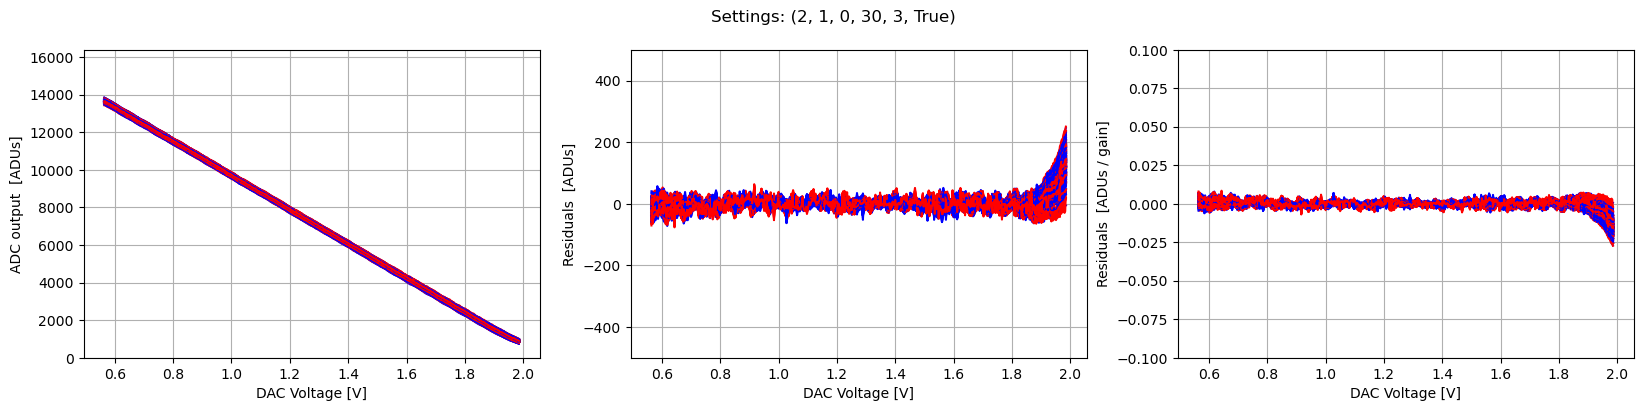

In [14]:
# Plot all, in odd/even fashion
col = 7

fig, axs = plt.subplots(1,3,figsize=(20,4))
plt.suptitle(('Settings: '+str(settings)))

axs[0].plot(dacValuesV,imgDesc[0:,0,col],label='Odd', c='blue')
axs[0].plot(dacValuesV,imgDesc[0:,1,col],label='Even', c='red')

for col in range(0,192,1):
    for row in range(2,3,2):
        axs[0].plot(dacValuesV,imgDesc[:,row,col], c='blue')
        axs[0].plot(dacValuesV,imgDesc[:,row+1,col], c='red')
        
axs[0].set_ylim(0,2**14)

axs[0].set_xlabel('DAC Voltage [V]')
axs[0].set_ylabel('ADC output  [ADUs]')
axs[0].grid()

for col in range(0,192,1):
    for row in range(2,3,2):
        gain = getGainLinFit(dacValuesV,imgDesc[:,row,col])
        axs[1].plot(dacValuesV,getResidualsLinFit(dacValuesV,imgDesc[:,row,col]), c='blue')
        axs[1].plot(dacValuesV,getResidualsLinFit(dacValuesV,imgDesc[:,row+1,col]), c='red')

# plt.ylim(-1000,1000)
axs[1].set_xlabel('DAC Voltage [V]')
axs[1].set_ylabel('Residuals  [ADUs]')
axs[1].set_ylim(-500,500)

axs[1].grid()

for col in range(0,192,1):
    for row in range(2,3,2):
        gain = getGainLinFit(dacValuesV,imgDesc[:,row,col])
        axs[2].plot(dacValuesV,getResidualsLinFit(dacValuesV,imgDesc[:,row,col])/gain, c='blue')
        axs[2].plot(dacValuesV,getResidualsLinFit(dacValuesV,imgDesc[:,row+1,col]/gain), c='red')

# plt.ylim(-1000,1000)
axs[2].set_xlabel('DAC Voltage [V]')
axs[2].set_ylabel('Residuals  [ADUs / gain]')
axs[2].set_ylim(-0.1,0.1)
axs[2].grid()


